In [36]:
# --- Imports
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score,  KFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Plotting 
import seaborn as sns
import matplotlib.pyplot as plt

# --- Settings
sns.set_theme(style='whitegrid')
sns.set_palette('viridis')
np.random.seed(42)

In [3]:
# loading a numpy-array containing the topographical data
z = np.load('topographical_data.npy')[4650:4900, 800:1050]

# --- Generating dataset
n = 250 # the square root of the number of datapoints
x, y = np.linspace(0,n,n), np.linspace(0, n, n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

z = z.ravel()

X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

k_folds = KFold(n_splits=10)

### OLS

Finding the optimal degree using `GridSearchCV`

In [35]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('linearregressor', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

1878.868761526055
{'poly__degree': 5}


### Ridge

Finding the optimal degree and value of $\lambda$ with `GridSearchCV`

In [36]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': np.logspace(-4, 1, 6)
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

1878.8693377381337
{'poly__degree': 5, 'ridge__alpha': 0.0001}


### Lasso

Finding the optimal degree and value of $\lambda$ with `GridSearchCV`

In [37]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'lasso__alpha': np.logspace(-4, 1, 6)
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

3690.8914016227304
{'lasso__alpha': 0.0001, 'poly__degree': 5}


c:\Users\maria\anaconda3\envs\fysstk3155\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.214e+07, tolerance: 6.344e+04
  model = cd_fast.enet_coordinate_descent(


## Higher Degree Fit

We do a higher degree fit with OLS and Ridge and find the optimal model using `GridSearchCV`

In [4]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

param_grid = [
    {
        'model': [LinearRegression()],
        'poly__degree': list(range(1, 31)),
    },
    {
        'model': [Ridge()],
        'poly__degree': list(range(1, 31)),
        'model__alpha': np.logspace(-4, 1, 6),
    }
]

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

101.51179469469297
{'model': LinearRegression(), 'poly__degree': 29}


We estimate the MSE using `cross_val_score`

In [9]:
np.random.seed(3155)

logmin, logmax, m = -4, 1, 6 # logspce start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)
degrees = list(range(1,31))

k = 10
k_folds = KFold(n_splits=k)
estimated_mse_OLS = np.zeros(len(degrees))
estimated_mse_Ridge = np.zeros((len(degrees), m))

for deg in degrees:
    pipeline_OLS = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler(),
            LinearRegression()
            )
    
    estimated_mse_folds_OLS = cross_val_score(estimator=pipeline_OLS, 
                                              X=X_train, 
                                              y=z_train, 
                                              scoring='neg_mean_squared_error', 
                                              cv=k_folds)
    
    estimated_mse_OLS[deg-1] = np.mean(abs(estimated_mse_folds_OLS))


    for idx, lmb in enumerate(llambdas):
        pipeline_Ridge = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler(),
            Ridge(alpha = lmb)
            )
        
        estimated_mse_folds_Ridge = cross_val_score(estimator=pipeline_Ridge, 
                                              X=X_train, 
                                              y=z_train, 
                                              scoring='neg_mean_squared_error', 
                                              cv=k_folds)

        # take abs() since we score using 'neg_mean_squared_error' and take the mean of all the folds
        estimated_mse_Ridge[deg-1, idx] = np.mean(abs(estimated_mse_folds_Ridge))

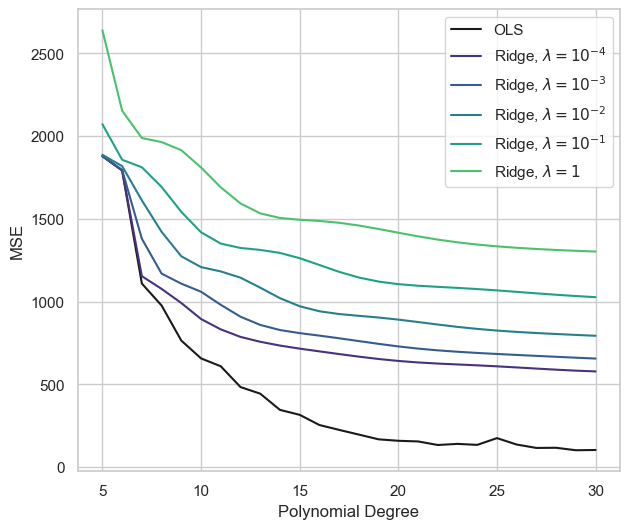

In [55]:
plt.figure(figsize=(7,6))
plt.plot(degrees[4:], estimated_mse_OLS[4:], label='OLS', color = 'k')
plt.plot(degrees[4:], estimated_mse_Ridge[4:, 0], label=r'Ridge, $\lambda = 10^{-4}$')
plt.plot(degrees[4:], estimated_mse_Ridge[4:, 1], label=r'Ridge, $\lambda = 10^{-3}$')
plt.plot(degrees[4:], estimated_mse_Ridge[4:, 2], label=r'Ridge, $\lambda = 10^{-2}$')
plt.plot(degrees[4:], estimated_mse_Ridge[4:, 3], label=r'Ridge, $\lambda = 10^{-1}$')
plt.plot(degrees[4:], estimated_mse_Ridge[4:, 4], label=r'Ridge, $\lambda = 1$')

plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.show()